This notebook demonstrates the capability of I-PINN for the problem of a sphere inside a unit cube. The sphere is characterized by a constant permeability of 1, while the surrounding cube features a variable permeability denoted by μ.
The problem is a 5D problem (3D, transient, and parametric)
By leveraging the capabilities of I-PINNs, this project aims to accurately model and predict the electromagnetic behavior with no external data.

In [1]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.jit import script, trace
import matplotlib.pyplot as plt

Below are necessary functions to calculate the residuals of the equations. The equations used are the first-order Maxwell's equations. The permeability in the domain is expressed as
 $$\mu = x_4 \cdot \hat{H} + 1$$
 where
- $x_4$ is a parameter.
- $\hat{H}$ denotes the Heaviside function on the interface.

In [2]:
def get_derivH(H,Y):

    gH=torch.autograd.grad(H,Y,grad_outputs=torch.ones_like(H),retain_graph=True,create_graph=True, allow_unused=True)[0]
    H_x=gH[:,0:1]
    H_y=gH[:,1:2]
    H_z=gH[:,2:3]
    H_t=gH[:,3:4]

    return H_x , H_y, H_z, H_t

def T_curl(Hx,Hy,Hz,Y):
    Hx_x , Hx_y, Hx_z, Hx_t = get_derivH(Hx,Y)
    Hy_x , Hy_y, Hy_z, Hy_t = get_derivH(Hy,Y)
    Hz_x , Hz_y, Hz_z, Hz_t = get_derivH(Hz,Y)

    #E=curl(V[0-->2])
    c1=(Hz_y-Hy_z)
    c2=(Hx_z-Hz_x)
    c3=(Hy_x-Hx_y)
    div=Hx_x + Hy_y + Hz_z
    return c1,c2,c3, Hx_t,Hy_t,Hz_t ,div

def equa_F(Hx,Hy,Hz,Ex,Ey,Ez,Y,rho,mu,Fx,Fy,Fz, tag):

    k=Y[:,4:5]

    r=torch.sqrt((0.5-Y[:,0:1])**2 + (0.5-Y[:,1:2])**2 + (0.5-Y[:,2:3])**2 )
    mu=k*torch.sigmoid(400*(r-0.25)) + 1

    rho=1

    cH1,cH2,cH3, Hx_t, Hy_t, Hz_t,div = T_curl(Hx,Hy,Hz,Y)
    cE1,cE2,cE3, Ex_t, Ey_t, Ez_t,divE = T_curl(Ex,Ey,Ez,Y)

    resx=mu*Hx_t + 1*cE1
    resy=mu*Hy_t + 1*cE2
    resz=mu*Hz_t + 1*cE3

    res2x=Ex*1/rho-cH1
    res2y=Ey*1/rho-cH2
    res2z=Ez*1/rho-cH3

    return resx,resy,resz, res2x,res2y,res2z,div,divE



Below is the I-PINN neural network

In [15]:

#weigh initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        #m.bias.data.fill_(0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#neural network architecture
class NetF(nn.Module):
    def __init__(self):
        super().__init__()
        n=50

        self.base = nn.Sequential(
          nn.Linear(12,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),

        )
        self.head1 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )

        self.head2 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )

        self.head3 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )

        self.head4 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )
        self.head5 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )
        self.head6 =  nn.Sequential(
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,n),
          nn.Tanh(),
          nn.Linear(n,1)
        )
    def forward(self, x):

        #in I-PINN, we augment the input vector with function containing high frequencies at the interface,
        # and with a vector field normal to the interface

        r=torch.sqrt((0.5-x[:,0:1])**2 + (0.5-x[:,1:2])**2 + (0.5-x[:,2:3])**2 )

        #the high-frequency functions

        mu=torch.sigmoid(50*(0.2-r))
        mu1=torch.sigmoid(100*(0.2-r))
        mu2=torch.sigmoid(200*(0.2-r))
        mu3=torch.sigmoid(300*(0.2-r))
        #the normal vector field
        mux,muy,muz,mut=get_derivH(mu,x)
        mod= 50*0.25

        #the augmented input vector
        Xa=torch.column_stack((x,mu,mux/mod,muy/mod,muz/mod ,mu1,mu2,mu3))

        #Forward pass
        x1 = self.base(Xa)
        x2=self.head1(x1)
        x3=self.head2(x1)
        x4=self.head3(x1)
        x5=self.head4(x1)
        x6=self.head5(x1)
        x7=self.head6(x1)

        return x2 ,x3 ,x4 ,x5,x6 ,x7


netF = NetF()
netF.apply(init_weights)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
netF=netF.to(device)

The function below is used to strongly impose the boundary conditions. We impose a dirichlet boundary conditions $H = [0,0,t]$ on the 4 sides of the cube, and $E=[0,0,0]$ on the top and bottom of the cube. The initial condition in zero.

In [17]:
def for_pass_F(X):
    Bx,By,Bz,Dx,Dy,Dz=netF(X)
    w1=X[:,0:1]
    w2=X[:,1:2]
    w3=1-w1
    w4=1-w2
    hb = X[:,2:3]
    ht = 1-hb
    t=X[:,3:4]

    d1= 1-torch.exp(-w1*1)
    d2= 1-torch.exp(-w2*1)
    d3= 1-torch.exp(-w3*1)
    d4= 1-torch.exp(-w4*1)
    d5= 1-torch.exp(-hb*1)
    d6= 1-torch.exp(-ht*1)
    dt= 1-torch.exp(-t*1)


    Hx = Bx*d2*d4*d5*d6*dt
    Hy = By*d1*d3*d5*d6*dt
    Hz = Bz *d1*d2*d3*d4*dt + 1*t

    Ex = Dx*d1*d3
    Ey = Dy*d2*d4
    Ez = Dz*d5*d6


    return Hx,Hy,Hz,Ex,Ey,Ez






In [18]:
L=[]

This function creates N random points inside the computational domain

In [19]:
def get_x(N):
  X=np.random.uniform(0,1,(N,5))
  X[:,4:5]= np.random.uniform(-0.6,0.6,(N,1))
  X=torch.tensor(X).float()
  return X

In [20]:
#this function plots the results Hz(x=0.5, y=0.5, z, mu=1.5)
def plot_results():

    Xt= get_x(5000).detach().to(device)
    Xt[:,0]=0.5
    Xt[:,1]=0.5
    Xt[:,3]=1
    mu=1.5
    Xt[:,4:5]=mu-1


    Xt.requires_grad=True


    Hx,Hy,Hz,Dx,Dy,Dz = for_pass_F(Xt)

    plt.plot(Xt[:,2].detach().cpu(),Hz.detach().cpu(),'*')


    plt.pause(0.005)


The function below introduce additional collocation points in critical parts of the domain. It creates a N random points in the computational domain, and keeps the n points with the highest residual. These 200 points are concatenated with the original collocation points.

In [21]:
def remesh(X0,N,n):
  X=get_x(N)
  X.requires_grad=True
  X = X.to(device)
  Rm=1

  r=torch.sqrt((0.5-X[:,0:1])**2 + (0.5-X[:,1:2])**2 + (0.5-X[:,2:3])**2 )
  mu=X[:,4:5]*torch.sigmoid(400*(r-0.2)) + 1

  Hx,Hy,Hz,Dx,Dy,Dz = for_pass_F(X)

  tag=0
  resx,resy,resz, res2x,res2y,res2z,div,divE = equa_F(Hx,Hy,Hz,Dx,Dy,Dz,X,1,mu,0,0,0,tag)
  cH1,cH2,cH3,h1t,h2t,h3t,divH = T_curl(mu*Hx,mu*Hy,mu*Hz,X)

  V= resx**2+resy**2+resz**2+ res2x**2+res2y**2+res2z**2+divH**2+divE**2


  nmax=torch.topk(V.reshape(-1), n).indices
  Xout=torch.concatenate((X0,X.detach()[nmax,:]) )
  return Xout

In [22]:
X= get_x(80000)#.to(device)
X=X.to(device)
X=remesh(X,200000,20000)


In [23]:
X.shape

torch.Size([100000, 5])

In [24]:

X.requires_grad=True
X = X.to(device)

In [25]:
def closure():

#calculating mu
  r=torch.sqrt((0.5-X[:,0:1])**2 + (0.5-X[:,1:2])**2 + (0.5-X[:,2:3])**2 )
  a=400
  mu=X[:,4:5]*torch.sigmoid(a*(r-0.2)) + 1

#calculating the electromagnetic field
  Hx,Hy,Hz,Dx,Dy,Dz = for_pass_F(X)

#calculating the residual
  tag=0
  resx,resy,resz, res2x,res2y,res2z,div,divE = equa_F(Hx,Hy,Hz,Dx,Dy,Dz,X,1,mu,0,0,0,tag)
  cH1,cH2,cH3, Hx_t,Hy_t,Hz_t ,divH = T_curl(mu*Hx,mu*Hy,mu*Hz,X)

#the loss function
  loss1=1*criterion(resx*T,resx*0) + 1*criterion(resy*T,resy*0) + 1*criterion(resz*T,resz*0) + 1*criterion(divH*T,divH*0)
  loss2=1*criterion(res2x*T,res2x*0) + 1*criterion(res2y*T,res2y*0) + 1*criterion(res2z*T,res2z*0) + 1*criterion(divE*T,divE*0)
  loss=1*loss1 + 1*loss2
  optimizer.zero_grad()

  L.append(loss.detach().cpu().numpy())

  loss.backward()
  return loss


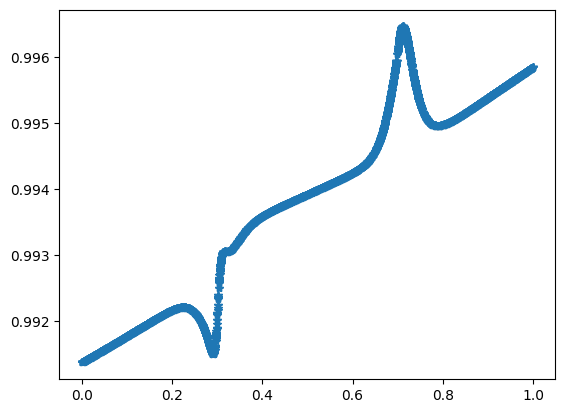

tensor(2.9585, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.3792, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.9930, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.6675, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.4878, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.3723, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.2988, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.2433, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.1931, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.1404, device='cuda:0', grad_fn=<MulBackward0>)


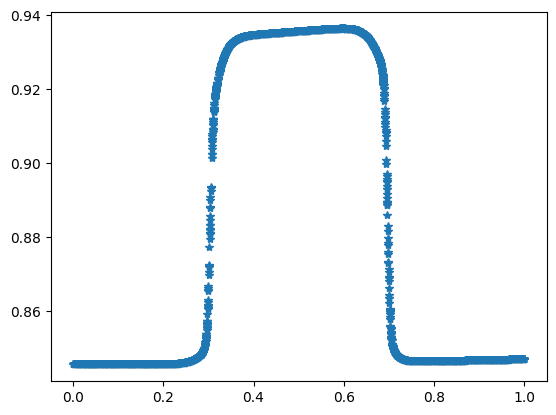

tensor(1.0524, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.9684, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.8959, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.8370, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.7823, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.7340, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6879, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6454, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6105, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5856, device='cuda:0', grad_fn=<MulBackward0>)


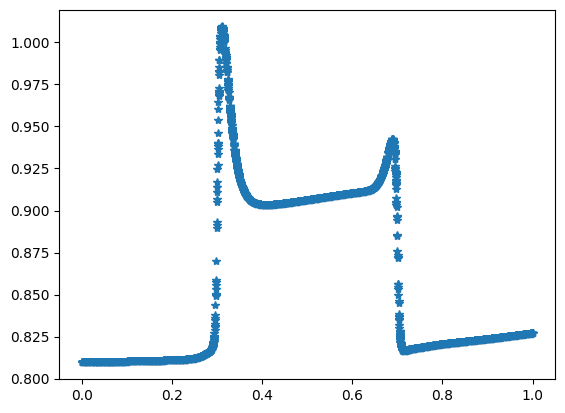

tensor(0.5685, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5549, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5430, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5322, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5228, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5144, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5071, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5006, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4948, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4895, device='cuda:0', grad_fn=<MulBackward0>)


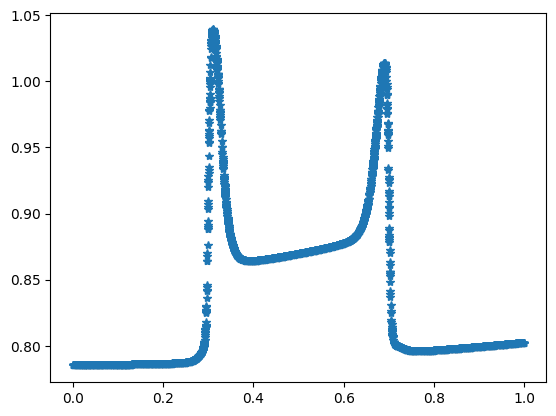

tensor(0.4847, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4802, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4760, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4720, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4683, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4647, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4613, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4580, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4548, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4517, device='cuda:0', grad_fn=<MulBackward0>)


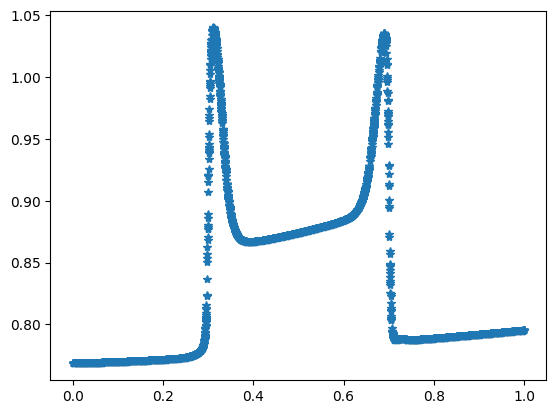

tensor(0.4487, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4457, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4428, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4399, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4371, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4343, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4315, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4288, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4261, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4234, device='cuda:0', grad_fn=<MulBackward0>)


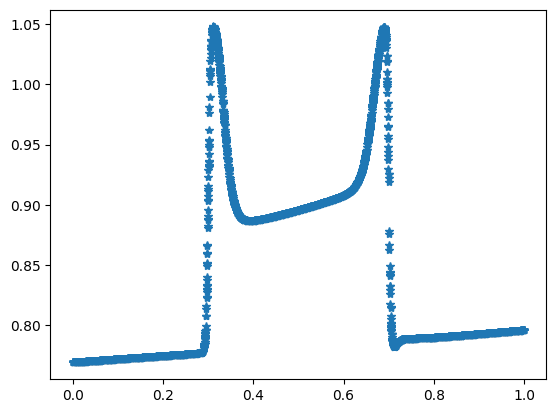

tensor(0.4207, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4180, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4152, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4124, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4095, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4066, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4036, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4005, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3973, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3939, device='cuda:0', grad_fn=<MulBackward0>)


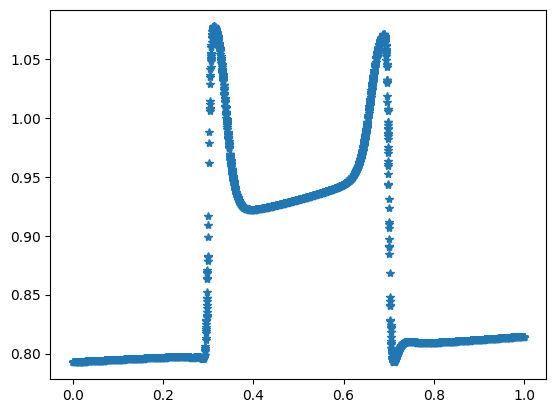

tensor(0.3904, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3867, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3827, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3783, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3720, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3573, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.3366, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2968, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2458, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2152, device='cuda:0', grad_fn=<MulBackward0>)


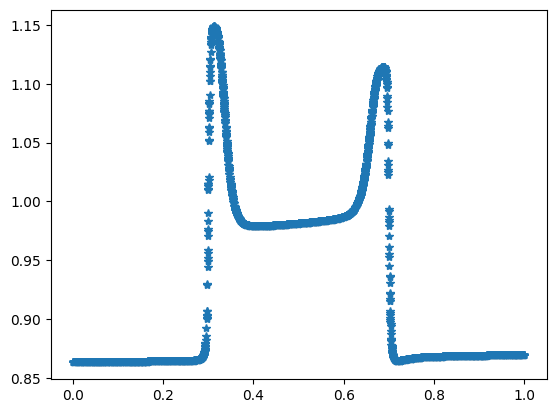

tensor(0.1883, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1698, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1576, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1483, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1408, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1343, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1287, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1238, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1201, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1157, device='cuda:0', grad_fn=<MulBackward0>)


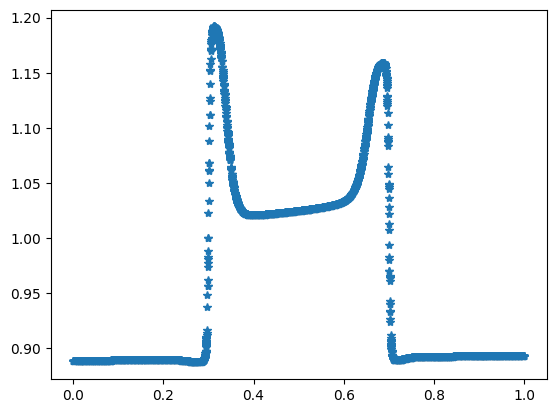

tensor(0.1122, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1088, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1059, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1031, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1005, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0980, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0956, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0932, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0909, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0887, device='cuda:0', grad_fn=<MulBackward0>)


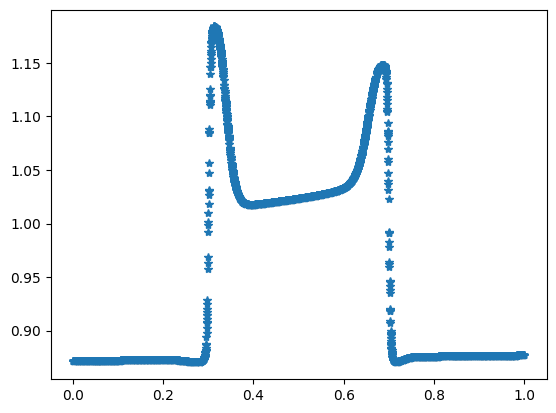

tensor(0.0865, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0844, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0823, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0804, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0786, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0768, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0750, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0733, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0717, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0700, device='cuda:0', grad_fn=<MulBackward0>)


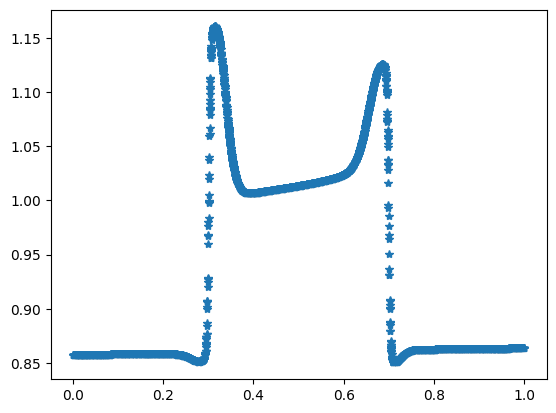

tensor(0.0685, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0668, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0652, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0637, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0622, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0608, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0594, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0580, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0566, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0553, device='cuda:0', grad_fn=<MulBackward0>)


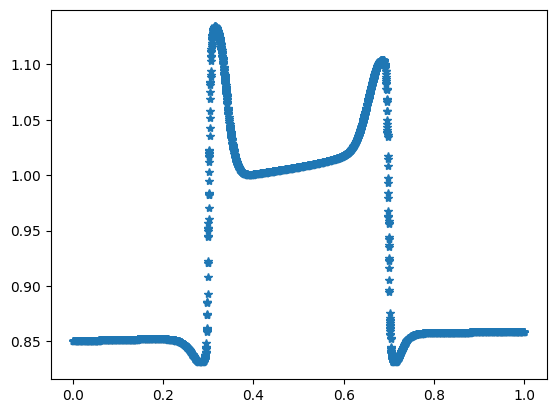

tensor(0.0540, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0528, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0517, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0507, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0497, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0486, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0477, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0468, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0459, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0451, device='cuda:0', grad_fn=<MulBackward0>)


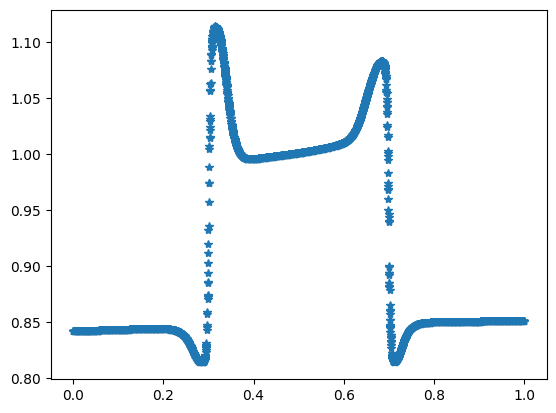

tensor(0.0443, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0435, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0427, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0420, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0412, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0405, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0402, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0393, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0386, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0379, device='cuda:0', grad_fn=<MulBackward0>)


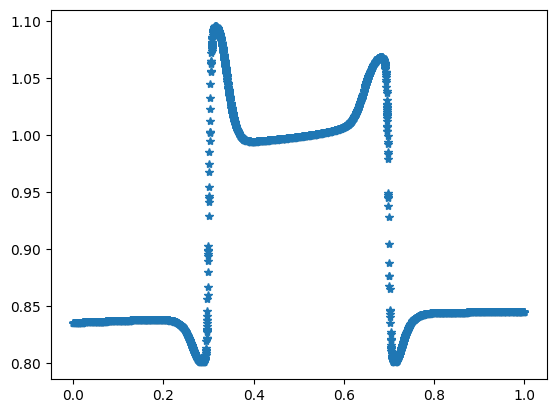

tensor(0.0373, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0367, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0361, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0355, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0350, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0344, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0339, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0334, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0333, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0326, device='cuda:0', grad_fn=<MulBackward0>)


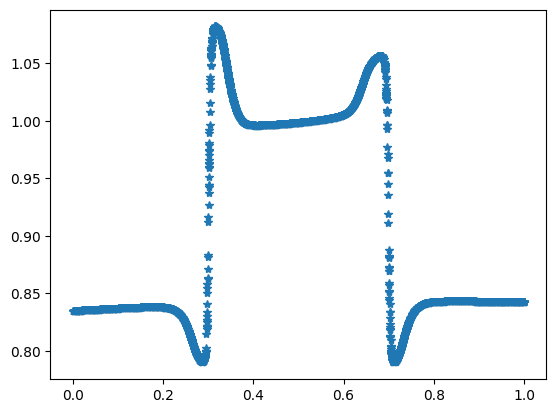

tensor(0.0321, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0316, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0312, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0307, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0303, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0299, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0295, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0291, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0288, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0284, device='cuda:0', grad_fn=<MulBackward0>)


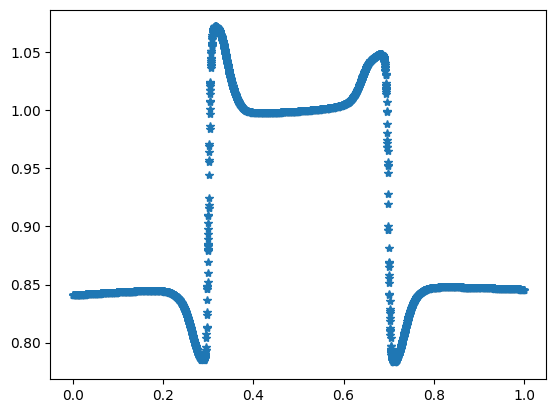

tensor(0.0286, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0279, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0274, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0270, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0267, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0264, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0261, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0258, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0255, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0252, device='cuda:0', grad_fn=<MulBackward0>)


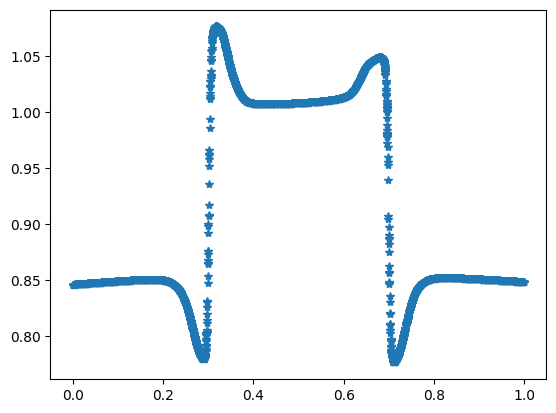

tensor(0.0250, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0247, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0253, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0244, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0240, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0238, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0236, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0234, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0232, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0230, device='cuda:0', grad_fn=<MulBackward0>)


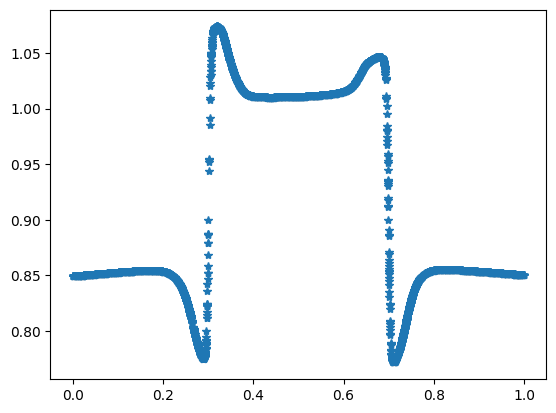

tensor(0.0228, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0226, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0224, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0227, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0221, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0219, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0217, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0216, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0214, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0213, device='cuda:0', grad_fn=<MulBackward0>)


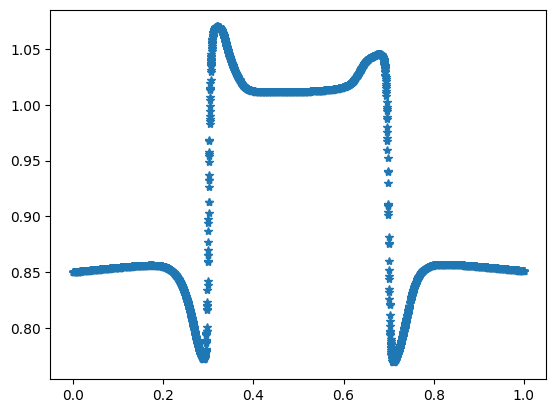

tensor(0.0211, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0214, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0210, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0207, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0206, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0204, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0203, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0202, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0200, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0200, device='cuda:0', grad_fn=<MulBackward0>)


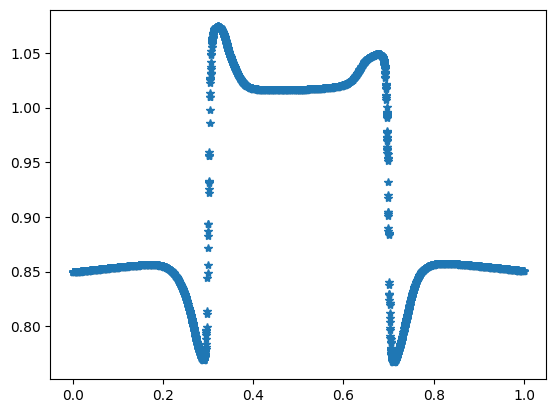

tensor(0.0203, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0197, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0196, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0195, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0194, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0193, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0191, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0190, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0189, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0189, device='cuda:0', grad_fn=<MulBackward0>)


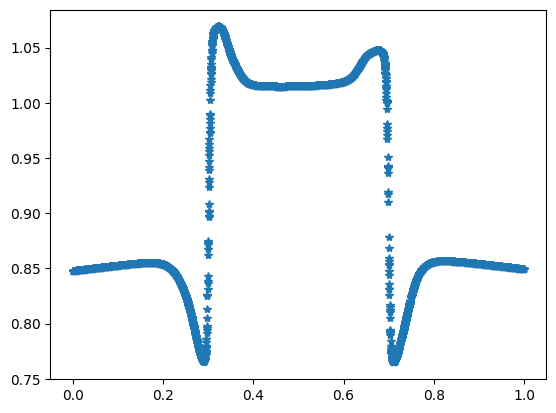

tensor(0.0190, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0186, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0175, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0164, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0155, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0147, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0142, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0137, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0133, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0128, device='cuda:0', grad_fn=<MulBackward0>)


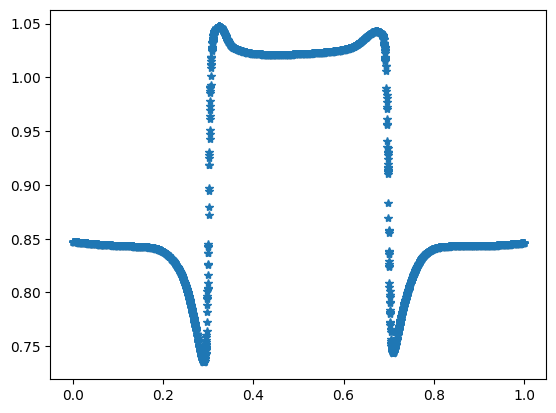

tensor(0.0124, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0120, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0117, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0113, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0108, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0104, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0101, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0098, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0092, device='cuda:0', grad_fn=<MulBackward0>)


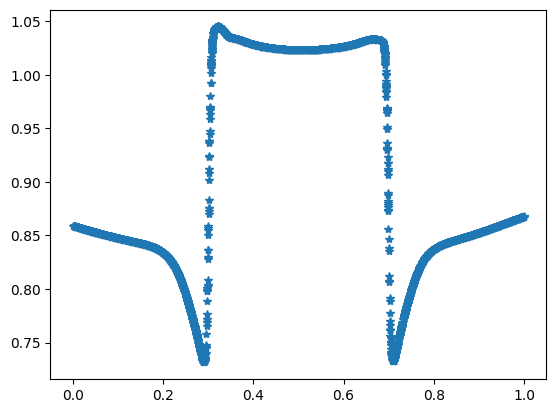

tensor(0.0090, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0087, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0085, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0083, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0081, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0079, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0077, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0075, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0073, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0071, device='cuda:0', grad_fn=<MulBackward0>)


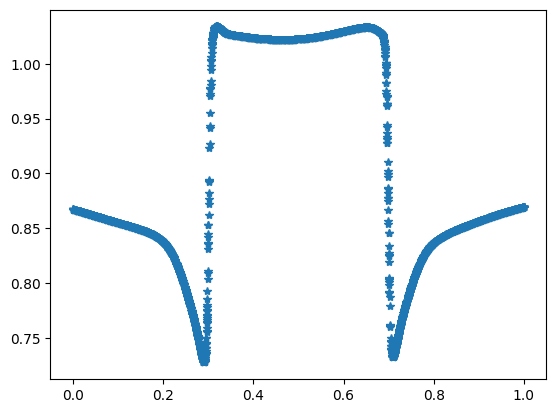

tensor(0.0069, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0067, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0066, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0065, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0062, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0060, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0059, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0057, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0056, device='cuda:0', grad_fn=<MulBackward0>)


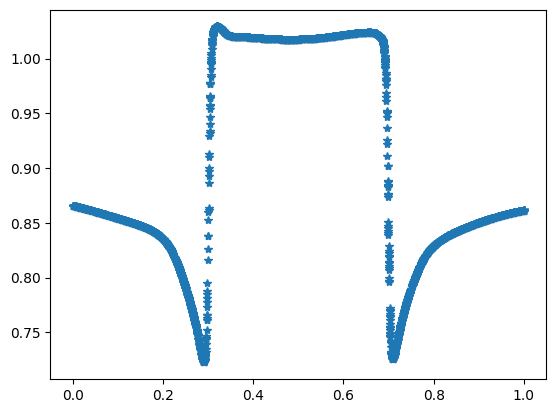

tensor(0.0054, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0049, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0048, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0047, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0046, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0045, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0044, device='cuda:0', grad_fn=<MulBackward0>)


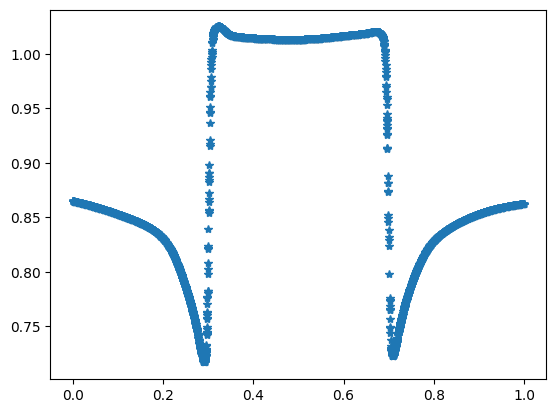

tensor(0.0043, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0040, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0040, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0039, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0038, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0038, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0037, device='cuda:0', grad_fn=<MulBackward0>)


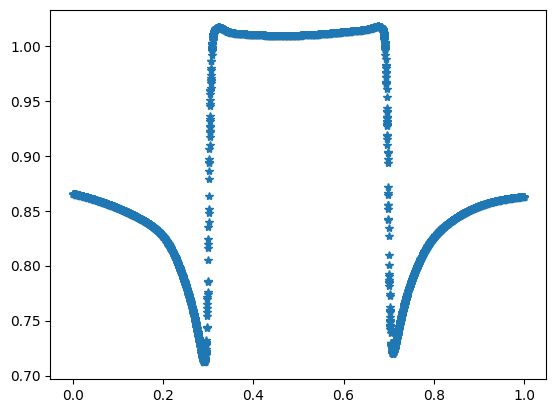

tensor(0.0037, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<MulBackward0>)


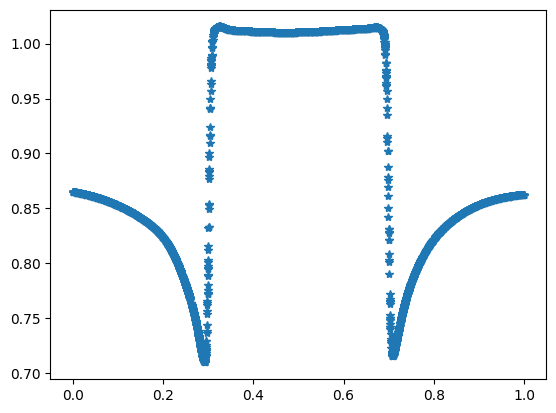

tensor(0.0032, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<MulBackward0>)


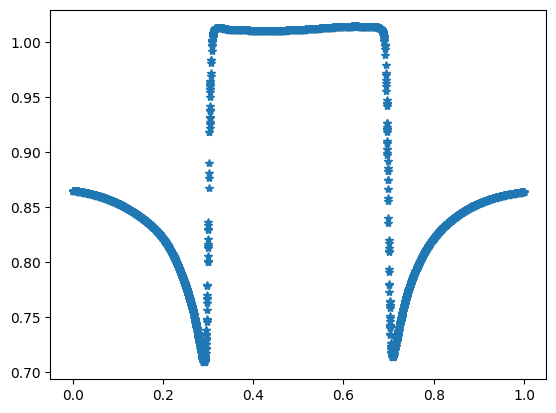

tensor(0.0029, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<MulBackward0>)


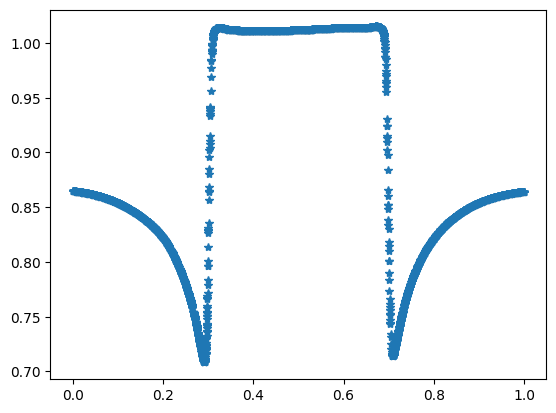

tensor(0.0026, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<MulBackward0>)


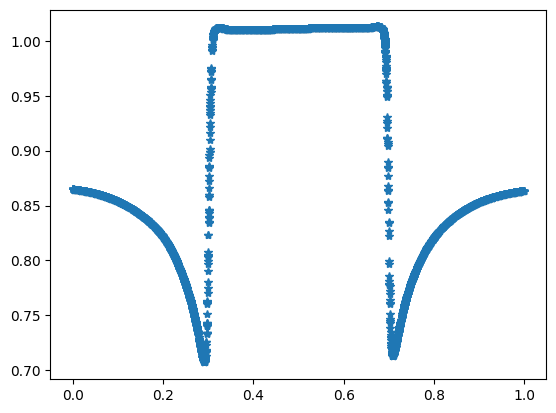

tensor(0.0025, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<MulBackward0>)


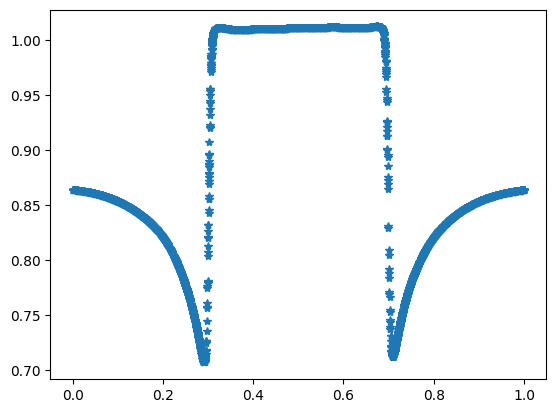

tensor(0.0024, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MulBackward0>)


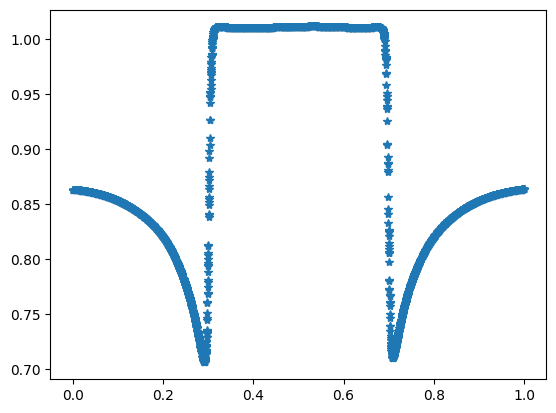

tensor(0.0023, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>)


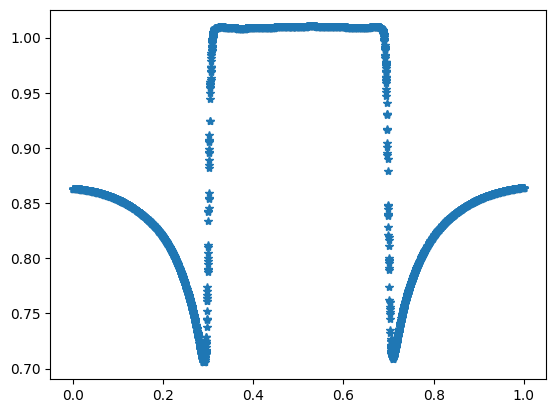

tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)


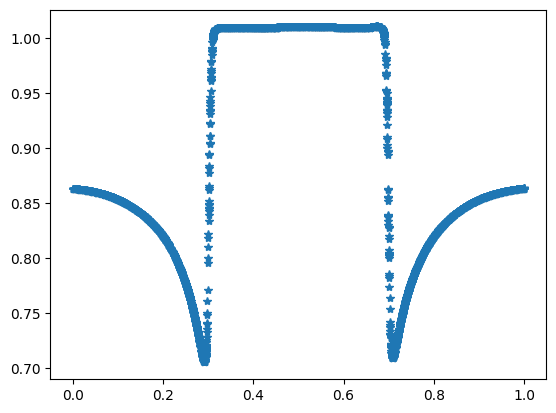

tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)


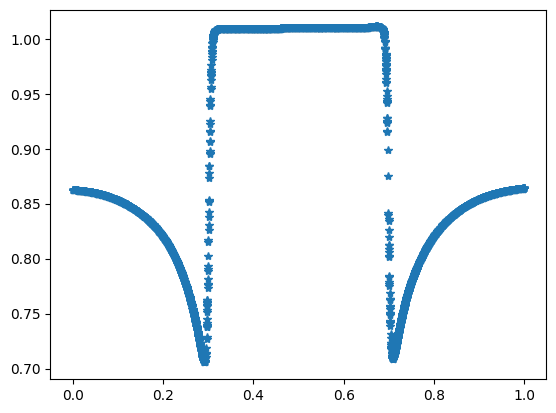

tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)


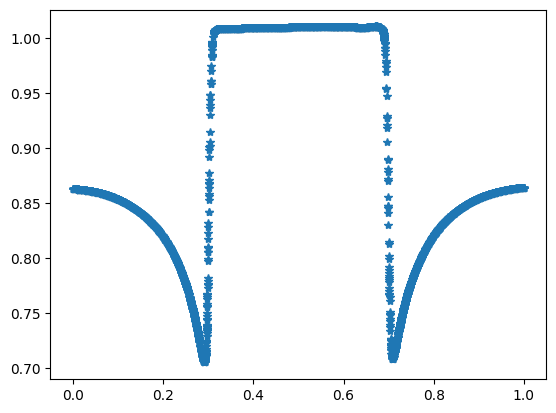

tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)


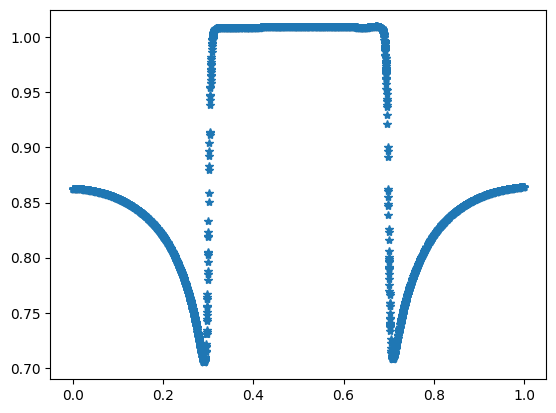

tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)


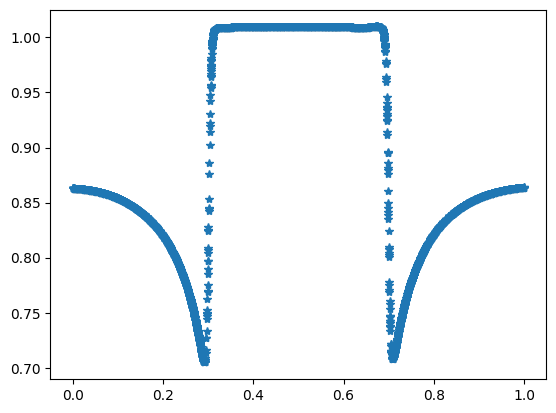

tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)


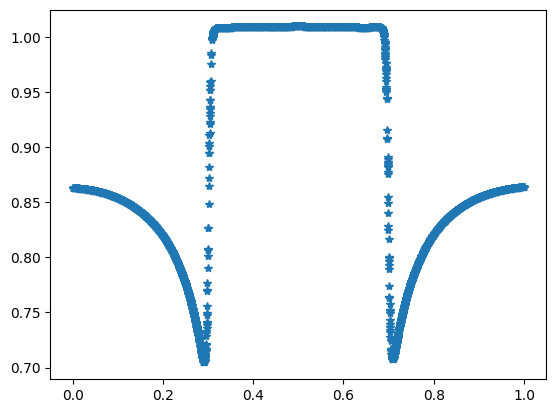

tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)


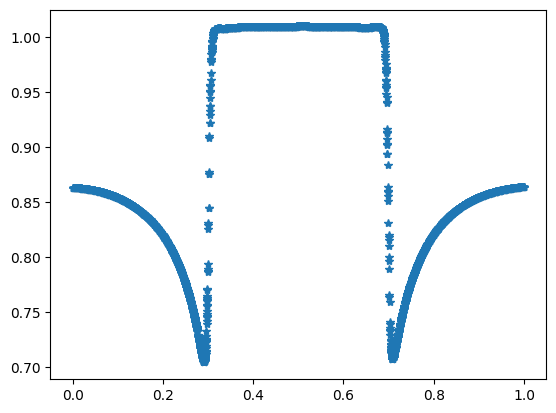

tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)


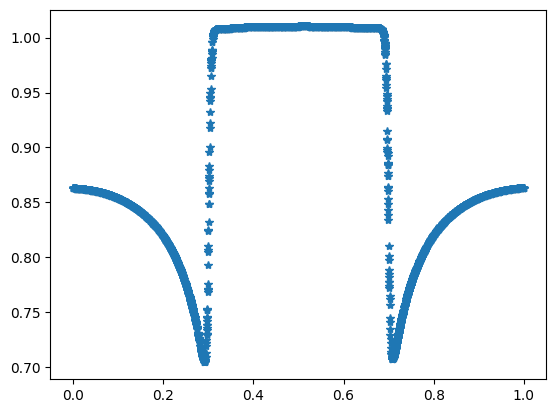

tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)


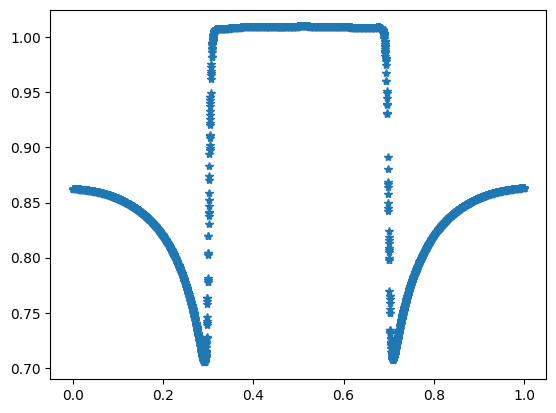

tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)


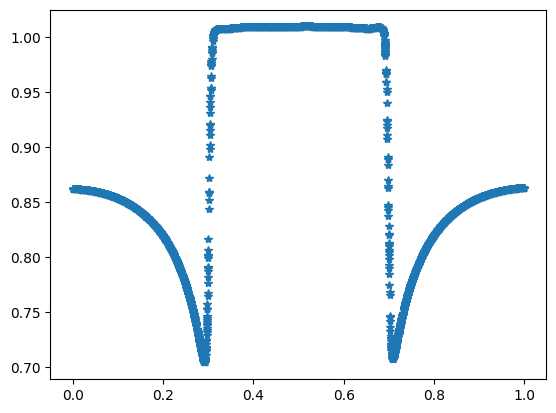

tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)


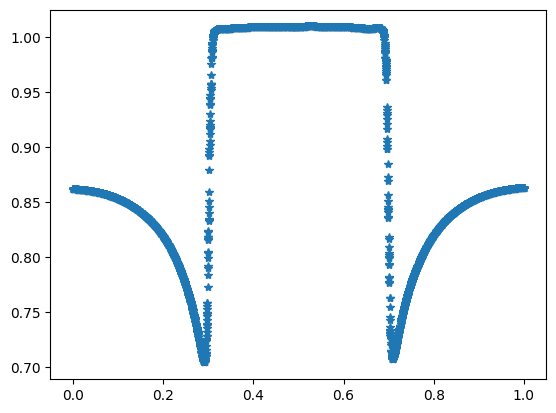

tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)


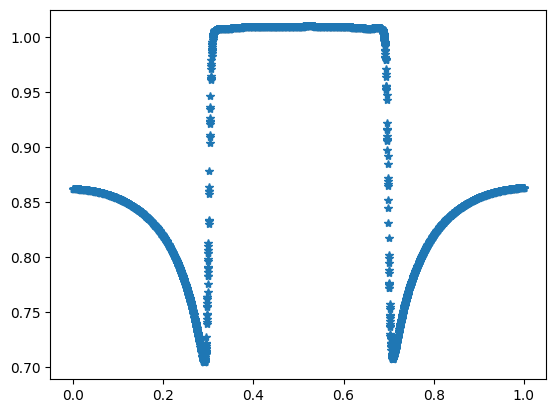

tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)


KeyboardInterrupt: 

In [26]:
learning_rate=5*10**-4
learning_rate2=1
criterion = nn.MSELoss()
optimizer = optim.Adam(netF.parameters(), lr=learning_rate)#, weight_decay=0.01)
optimizer2 = optim.LBFGS(netF.parameters(), lr=learning_rate2)

T=1
#training with 2000 adams iterations and 4000 L-BFGS iterations
for i in range(2000):
  loss=optimizer.step(closure)
  if (i%100 ==0):
    plot_results()
  if (i%10==0):
      print(loss*1)

for i in range(400):
  loss=optimizer2.step(closure)
  L.append(loss.detach().cpu().numpy())
  if (i%10 ==0):
    plot_results()
  if (i%1==0):
      print(loss*1)


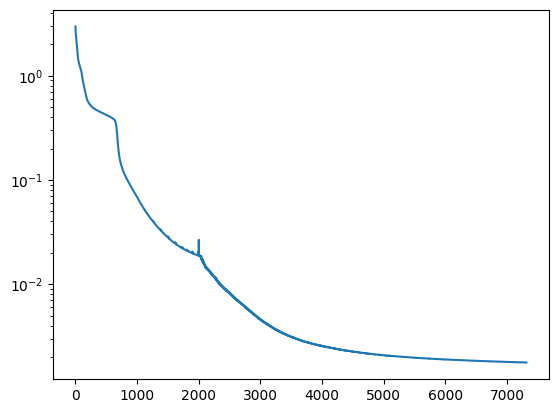

In [27]:
plt.semilogy(L)

In [31]:
ylist = np.linspace(0, 1, 400)
zlist = np.linspace(0, 1, 400)
ym, zm = np.meshgrid(ylist, zlist)

xp=0.5
tp=1
mu=1.5
ten=np.column_stack((ym.reshape(-1,1)*0 + xp  ,  ym.reshape(-1,1)  ,  zm.reshape(-1,1) ,  ym.reshape(-1,1)*0+tp, ym.reshape(-1,1)*0 + mu-1 ))
ten=torch.tensor(ten).float().to(device)
ten.requires_grad=True


We vizualize the results for $H_z( x=xp ,y,z,t=tp)$, and a chosen $\mu$ outside the sphere




In [43]:

Hx,Hy,Hz,Dx,Dy,Dz = for_pass_F(ten)


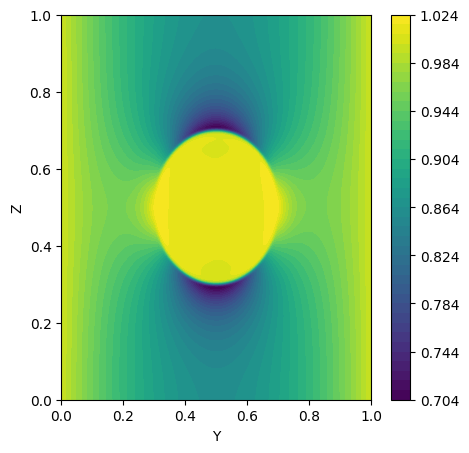

In [44]:
vnp=Hz.reshape(400,400).detach().cpu().numpy()

fig,ax=plt.subplots(1,1,figsize=(5,5))
cp = plt.colorbar(ax.contourf(ym, zm,vnp,50))
#plt.title('H_z for a=0.5 and')
plt.xlabel('Y')
plt.ylabel('Z')

# Show the plot
plt.show()

We vizualize the results for $H_y( x=xp ,y,z,t=tp)$, and a chosen $\mu$ outside the sphere




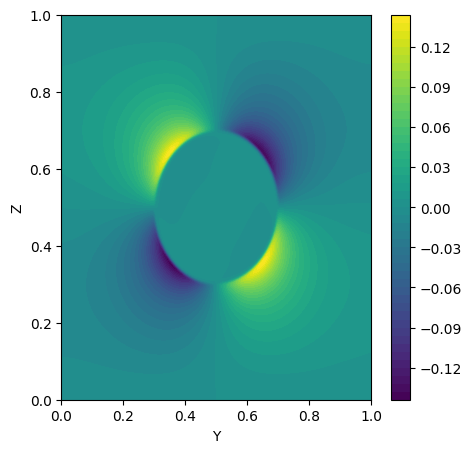

In [45]:
vnp=Hy.reshape(400,400).detach().cpu().numpy()

fig,ax=plt.subplots(1,1,figsize=(5,5))
cp = plt.colorbar(ax.contourf(ym, zm,vnp,50))
#plt.title('H_z for a=0.5 and')
plt.xlabel('Y')
plt.ylabel('Z')

# Show the plot
plt.show()